# Introduction

Welcome! The goal of this workbook is to walkthrough the various examples detailed in the accompanying Excel workbooks to *How to Measure Anything*.  Upon reviewing all of those example we will seek to create some helper function for performing common tasks in Applied Information Economics.  We will primarily lean on the numpy and PyMC3 libraries, with PyMC3 also recieving support from Theano.  PyMC3 is capable of performing scalable Beyesian Inference using modern approaches to Monte Carlo simulation and Beysian Variational Inference.  

## Example from Chapter 6: Monte Carlo Simulation
The purpose of this example is to model the decision of purchasing a new machine.  Its a simple model with only a few variables, but will nicely demonstrate PyMC3's abilitiy to model these types of problems.

In this scenario the machine we desire to purchase costs \$400,000.  We therefore have to make at least that much in savings in order to justify those savings.  We consulted calibrated experts and came up with 4 90% confidence intervals:

|Ranges	| Maintenance Savings (\$ per unit produced)	|Labor Savings (\$ per unit produced)	|Raw Materials Savings (\$ per unit produced)|	 Production Level (units per year) |
|:---:|:---:|:---:|:---:|:---:|
|Upper Bound	|\$20| 	\$8 |	\$9 |	 35,000 |
|Mean	|\$15 	|\$3| 	\$6 |	 25,000 |
|Lower Bound	|\$10| 	-\$2| \$3 |	 15,000 |

One note, it is historically been typical to use standard deviation, $\sigma$, to paramatarize normal distributions, but I will tend to favor its precisions, $\frac{1}{\sigma^2} = \tau$.  For some intuition, as $\tau$ increases, we have greater certainty about the value. To make the conversation from 90% CIs to precision easier, I derived a helper function.

In [75]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import theano.tensor as T
import matplotlib.pyplot as plot

from scipy import integrate

def CItoNorm(lower, upper):
    mu = (upper + lower) / 2
    tau = 10.8241 / (upper - lower) ** 2
    return mu, tau

With that in place we can now paramatarize the priors of our model and specify the rest.

In [4]:
N_samples = 10000

mu_maint, tau_maint = CItoNorm(10, 20)
mu_labor, tau_labor = CItoNorm(-2, 8)
mu_mat, tau_mat = CItoNorm(3, 9)
mu_prod, tau_prod = CItoNorm(15000, 35000)

with pm.Model() as first_model:
    # Priors
    maint = pm.Normal("maint", mu=mu_maint, tau=tau_maint)
    labor = pm.Normal("labor", mu=mu_labor, tau=tau_labor)
    materials = pm.Normal("materials", mu=mu_mat, tau=tau_mat)
    production = pm.Normal("production", mu=mu_prod, tau=tau_prod)
    
    # Combine to get savings
    savings = pm.Deterministic("savings", (maint + labor + materials) * production)
    
    trace = pm.sample(N_samples)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -0.015106: 100%|█████████████████████████████████████████████| 200000/200000 [00:10<00:00, 18650.13it/s]
Finished [100%]: Average ELBO = -0.027134
100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1476.37it/s]


After running the above simulation we will have successfully sampled 10,000 simulations using NUTS


maint:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  14.978           3.085            0.029            [8.806, 20.876]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  8.898          12.912         15.007         17.036         20.988


labor:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.982            2.994            0.032            [-2.792, 8.900]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -2.926         0.983          3.009          4.995          8.817


materials:

  Mean             SD               MC Error         95% HPD interval
  ------------------

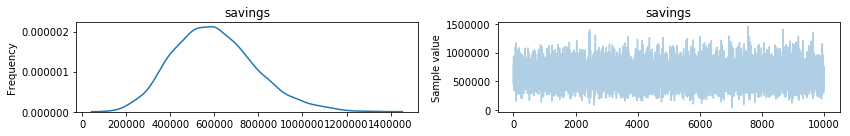

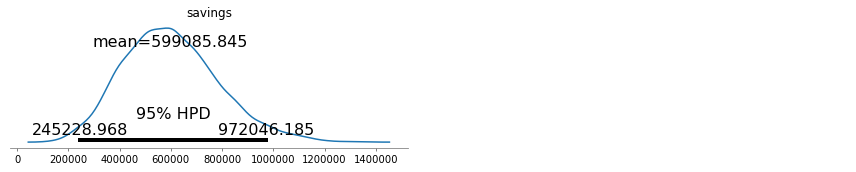

In [65]:
def summarize_trace(trace):
    pm.plots.traceplot(trace, varnames=["savings"])
    pm.plots.plot_posterior(trace, varnames=["savings"], kde_plot=True)
    pm.summary(trace)
    
summarize_trace(trace)

In [57]:
def prob_break_even(trace):
    return sum(trace.savings > 4e5) / trace.savings.shape[0]

prob_break_even(trace)

0.85819999999999996

So, taking a look at the distribution, we can already see that 400,000 is fairly low risk.  A simple calculation yields ~85% chance that we get or exceed 400,000 in savings.  Now, leadership might feel comfortable proceeding with this simple analysis performed.  However, we can further quantify the risk as a dollar value by finding the Expected Opportunity Loss.  To do this we need to lay out the decision and loss.

| Decision | Savings >= 400,000 | Savings < 400,000 |
|:--------:|:------------------:|:-----------------:|
|          |       p = .86      |      p = .14      |
| Buy Machine | 0 | 400,000 - Savings |
| Don't Buy | Savings - 400,000 | 0 |

In [58]:
def calc_mid_points(edges):
    mid_points = np.zeros(edges.shape[0]-1)
    for i in range(mid_points.shape[0]):
        mid_points[i] = (edges[i] + edges[i+1])/2
    return(mid_points)

def expected_values(trace, bins=10000):
    sims = pm.trace_to_dataframe(trace)
    hist, edges = np.histogram(sims.savings, density=False, bins=bins)
    expect = pd.DataFrame({"mp" : calc_mid_points(edges), "counts" : hist})
    expect["prob"] = expect.counts / bins
    expect['exp_buy_loss'] = expect.prob * np.where(expect.mp > 4e5, 0, 4e5 - expect.mp)
    expect['exp_dont_buy_loss'] = expect.prob * np.where(expect.mp > 4e5, expect.mp - 4e5, 0)
    return expect

Essentially we break up the distribution sampled above into buckets and approximate the probability of an event happening in that bucket.  We can then multiply the probability of that value occuring by the loss associated with that value to obtain the Expected Opportunity Loss.  I calculated this for both sides of the decision.

In [59]:
def reveal_expected(trace):
    expected = expected_values(trace)
    print("Expected Loss for Buying Machine:", sum(expected.exp_buy_loss))
    print("Expected Loss for Not Buying Machine:", sum(expected.exp_dont_buy_loss))
    
reveal_expected(trace)

Expected Loss for Buying Machine: 10026.7045854
Expected Loss for Not Buying Machine: 209111.804743


Our results indicate that the risk associated with buying the machine is \$10,026, whereas not buying the machine as a risk of \$209,111.  Clearly we take on less risk by buying the machine.  Our overall EOL for buying the machine also happens to be the EVPI.  That is, we should at most spend ~\$10,000 on measurements in order to completely eliminate our risk. 

The next step might be to try to identify which variable would have the largest impact on our EOL.  This would give us a good hint at what would yeild the highest value measurements.  This simply involves collapsing one of our variables from a probability distribution to a scalar.  Hubbard might have some advice on what value to choose (mean of our current distribution? ideal value?).  I am going to take the approach of simply fixing each variable at the midpoint of our current ranges.

TODO: Figure out how to do this step programmatically.

In [60]:
with pm.Model() as fixed_maint_model:
    # Priors
    labor = pm.Normal("labor", mu=mu_labor, tau=tau_labor)
    materials = pm.Normal("materials", mu=mu_mat, tau=tau_mat)
    production = pm.Normal("production", mu=mu_prod, tau=tau_prod)
    
    # Combine to get savings
    savings = pm.Deterministic("savings", (15 + labor + materials) * production)
    
    fixed_maint_trace = pm.sample(N_samples)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -0.019166: 100%|█████████████████████████████████████████████| 200000/200000 [00:09<00:00, 21770.63it/s]
Finished [100%]: Average ELBO = -0.019747
100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1425.34it/s]


In [68]:
with pm.Model() as fixed_labor_model:
    # Priors
    maint = pm.Normal("maint", mu=mu_maint, tau=tau_maint)
    materials = pm.Normal("materials", mu=mu_mat, tau=tau_mat)
    production = pm.Normal("production", mu=mu_prod, tau=tau_prod)
    
    # Combine to get savings
    savings = pm.Deterministic("savings", (maint + 3 + materials) * production)
    
    fixed_labor_trace = pm.sample(N_samples)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -0.032559: 100%|█████████████████████████████████████████████| 200000/200000 [00:09<00:00, 20821.17it/s]
Finished [100%]: Average ELBO = -0.033498
100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1585.72it/s]


In [69]:
with pm.Model() as fixed_mat_model:
    # Priors
    maint = pm.Normal("maint", mu=mu_maint, tau=tau_maint)
    labor = pm.Normal("labor", mu=mu_labor, tau=tau_labor)
    production = pm.Normal("production", mu=mu_prod, tau=tau_prod)
    
    # Combine to get savings
    savings = pm.Deterministic("savings", (maint + labor + 6) * production)
    
    fixed_mat_trace = pm.sample(N_samples)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -0.031163: 100%|█████████████████████████████████████████████| 200000/200000 [00:11<00:00, 17892.49it/s]
Finished [100%]: Average ELBO = -0.025363
100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1391.20it/s]


In [70]:
with pm.Model() as fixed_prod_model:
    # Priors
    maint = pm.Normal("maint", mu=mu_maint, tau=tau_maint)
    labor = pm.Normal("labor", mu=mu_labor, tau=tau_labor)
    materials = pm.Normal("materials", mu=mu_mat, tau=tau_mat)
    
    # Combine to get savings
    savings = pm.Deterministic("savings", (maint + labor + materials) * 25000)
    
    fixed_prod_trace = pm.sample(N_samples)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -0.028314: 100%|█████████████████████████████████████████████| 200000/200000 [00:13<00:00, 14410.81it/s]
Finished [100%]: Average ELBO = -0.032155
100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1666.72it/s]


In [67]:
reveal_expected(fixed_maint_trace)

Expected Loss for Buying Machine: 7953.37040941
Expected Loss for Not Buying Machine: 206489.059736


In [71]:
reveal_expected(fixed_labor_trace)

Expected Loss for Buying Machine: 7964.82381676
Expected Loss for Not Buying Machine: 206175.924817


In [72]:
reveal_expected(fixed_mat_trace)

Expected Loss for Buying Machine: 8685.68882845
Expected Loss for Not Buying Machine: 210125.215009


In [73]:
reveal_expected(fixed_prod_trace)

Expected Loss for Buying Machine: 1916.71270597
Expected Loss for Not Buying Machine: 201099.027869



maint:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  15.001           3.003            0.027            [9.006, 20.728]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  9.135          12.949         15.048         17.007         20.892


labor:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.995            2.994            0.030            [-2.870, 8.810]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -2.881         0.986          3.026          4.975          8.806


materials:

  Mean             SD               MC Error         95% HPD interval
  ------------------

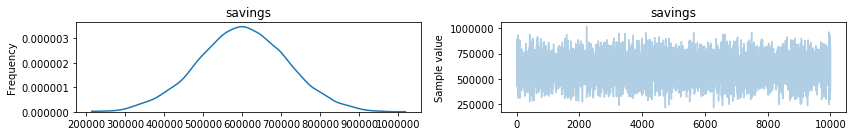

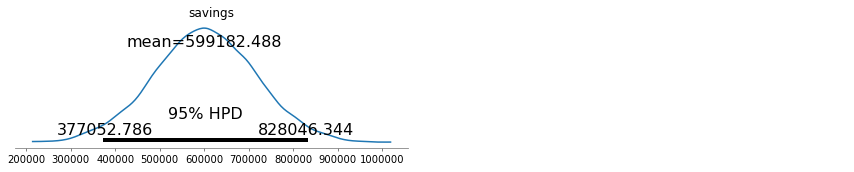

In [74]:
summarize_trace(fixed_prod_trace)

So, our analysis has yielded some results.  If we were interested in further measurement, then trying to narrow our CI around production would be the best use of our time and money.  One experiment we might try is simple measuring our current level of production over the past several years.  Bayesian Inference could take our current prior and, given an observed dataset, mold it into one which most closely matches the data.

# Continuous Decision Example

The other type of decisions we are likely to try to make is continuous instead of being discrete.  In this case we would like to set a proction level or some such decisions which requires choosing a value instead of simply choosing between two alternatives. 